In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit


from altaipony.fakeflares import flare_model
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve

from astropy import units as u
from astropy.modeling import models
from astropy.constants import sigma_sb

def extract(data, stri):
    """Quick function to extract light curve columns from a fits file"""
    return data[stri].byteswap().newbyteorder()

def flare_factor(teff, radius, wav, resp,  tflare=10000):
    """Calculate the flare energy factor in ergs, following Shibayama et al. (2013)

    Parameters
    ----------
    teff : float
        Stellar effective temperature in Kelvin.
    radius : float
        Stellar radius in solar radii.
    wav : array
        Array of wavelengths in nanometers.
    resp : array
        Array of bandpass responses.
     tflare : float
        Flare temperature in Kelvin.
    
    Returns
    -------
    factor : float
        Flare energy factor in ergs/s.
    """

    # blackbody
    bb = models.BlackBody(temperature=teff * u.K)

    # blackbody flux in TESS band
    bbwavs = bb(wav * u.nm)  * resp

    fluxs = np.trapz(bbwavs.value, wav)

    # blackbody
    bb = models.BlackBody(temperature=tflare * u.K)

    # blackbody flux in TESS band
    bbwavf = bb(wav * u.nm)  * resp

    fluxf = np.trapz(bbwavf.value, wav)

    ratio = fluxs / fluxf

    factor = ratio * np.pi * (radius * u.R_sun) ** 2 * sigma_sb * (tflare * u.K)**4

    return factor.to("erg/s")



In [15]:
# GET THE IMAGE DATA -----------------------------------------------------------
file = "visit_1001"

# file name
IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00002/hip67522_CHEOPS-products-{file}_im.fits'

# open the fits file
hdulist = fits.open(IMG)
print(f"Imagette file found for {file}:\n {IMG}\n")

# get the image data
image_data = hdulist[1].data

# get LC data
t = extract(image_data, "BJD_TIME")
f = extract(image_data, "FLUX")
ferr = extract(image_data, "FLUXERR")
roll = extract(image_data, "ROLL")
dT = extract(image_data, "thermFront_2")
flag = extract(image_data, "FLAG")
bg = extract(image_data, "BG")
xc = extract(image_data, "XC")
yc = extract(image_data, "YC")

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"


Imagette file found for visit_1001:
 ../data/hip67522/CHEOPS-products-visit_1001/Outdata/00002/hip67522_CHEOPS-products-visit_1001_im.fits



/tmp/ipykernel_4534/4141350332.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-visit_1001/Outdata/00002/residuals_sa.fits'>
  hdulist = fits.open(IMG)


/tmp/ipykernel_4534/2373880939.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-visit_1001/Outdata/00002/hip67522_CHEOPS-products-visit_1001_im.fits'>
  hdulist = fits.open(IMG)


Residuals image file found for visit_1001:
 ../data/hip67522/CHEOPS-products-visit_1001/Outdata/00002/residuals_sa.fits



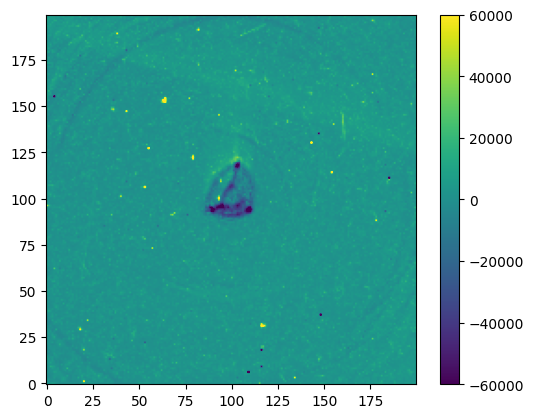

In [16]:
# get the image of the residuals from data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/residuals_im.fits
%matplotlib inline
IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00002/residuals_sa.fits'
hdulist = fits.open(IMG)
print(f"Residuals image file found for {file}:\n {IMG}\n")

# get the image data
image_data = hdulist[0].data


# sum over the first axis
image_data = image_data.sum(axis=0)

# show the image
plt.imshow(image_data, cmap="viridis", origin="lower", vmin=-60000, vmax=60000)
plt.colorbar()
plt.show()  


In [17]:

# initial masking

egress = 2460483.18998
mask = (f < 2.96e6) & (f > 2.3e6) & (flag==0)#&  (t>egress+0.02)#(t > egress + 0.03)~((2460413.39403 - 0.02<t) & 2460413.59495



print(f"Initial mask: {mask.sum()} data points")


Initial mask: 3100 data points


In [18]:
%matplotlib inline
t = t[mask]
f = f[mask]
roll = roll[mask]
ferr = ferr[mask]
dT = dT[mask]
flag = flag[mask]
bg = bg[mask]
xc = xc[mask]
yc = yc[mask]


Text(0.5, 1.0, 'Initial light curve, masking transit and outliers')

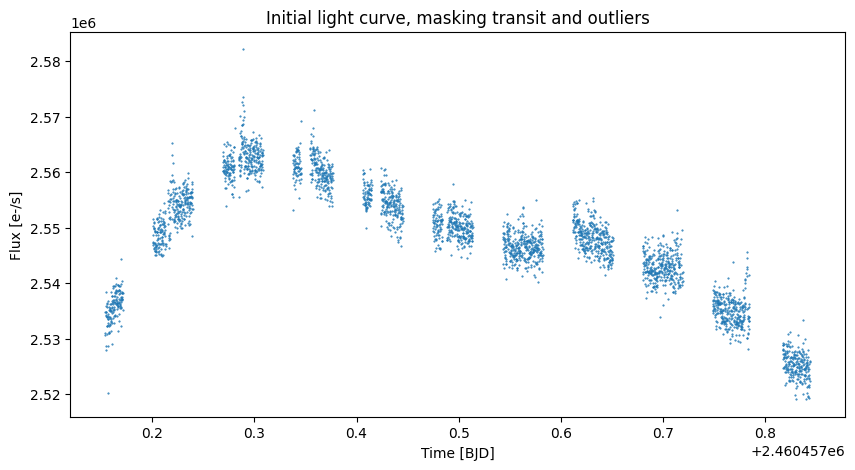

In [19]:

fs = f-bg

plt.figure(figsize=(10, 5))
# plt.plot(t, f, ".", markersize=1)
plt.plot(t, f, ".", markersize=1)

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Initial light curve, masking transit and outliers")
# plt.savefig(f"../plots/{file}/flares/hip67522_initial_lc.png")
# plt.xlim(2460457.7)

Text(0.5, 1.0, 'First polynomial fit to the light curve w/o flare')

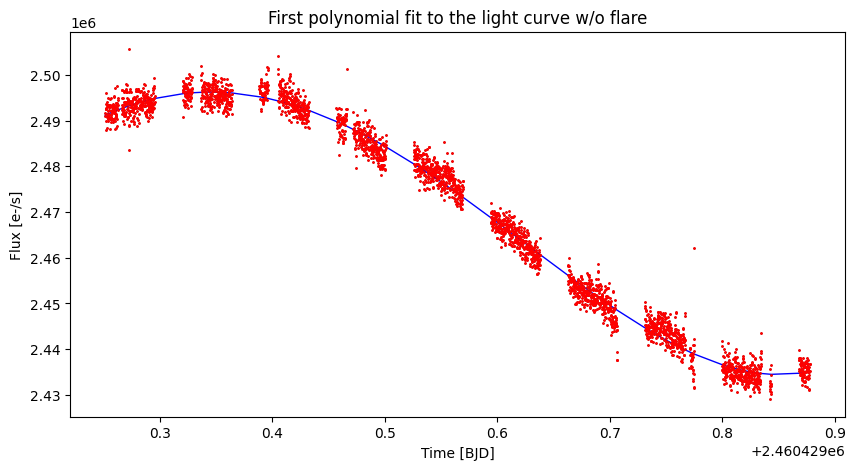

In [8]:

# 5th degree polynomial with a time offset
offset2 = t[-1]
def func(x, a, b, c, d, e, f, offset):
    return (f * (x - offset2 + offset)**5 + 
            e * (x - offset2 + offset)**4 + 
            a * (x - offset2 + offset)**3 + 
            b * (x - offset2 + offset)**2 + 
            c * (x - offset2 + offset) + d
)

popt, pcov = curve_fit(func, t, f, p0=[-1.45888787e+04, -1.41685433e+08, -1.03596058e+09,  1.00000000e+00,
        1.19292031e-02, -2.42900480e-09,  8.42088604e-01])

fitted = func(t, *popt)



plt.figure(figsize=(10, 5))

plt.plot(t, fitted, color="blue", lw=1)
plt.plot(t, f, ".", markersize=1, color="black")
plt.plot(t, f, ".", markersize=2, color="red")

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("First polynomial fit to the light curve w/o flare")
# plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_init.png")

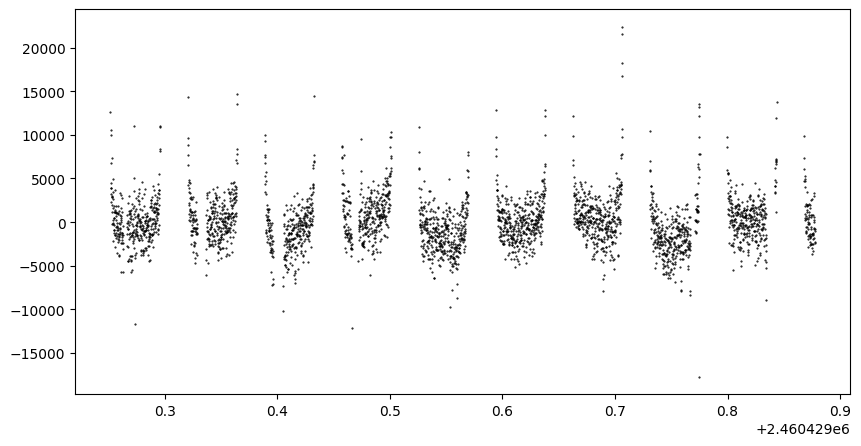

In [34]:
# subtract fitted from f
med = np.median(f)
f_sub = f - fitted + med

# fit bg to the residuals by scaling bg linearly
def func(a, b):
    return a * bg + b - f_sub

res0 = 91396180523951.53
plt.figure(figsize=(10, 5))
for a in np.linspace(500, 700, 80):
    for b in np.linspace(2.4e6, 2.5e6, 80):
        # plt.plot(t, func(a, b), ".", markersize=1)
        res = np.sum(func(a, b)**2)
        if res < res0:
            res0 = res
            a0 = a
            b0 = b


# plt.figure(figsize=(10, 5)) 
# plt.plot(t, f_sub, ".", markersize=1)
plt.plot(t, func(a0, b0), ".", markersize=1, c="k")

# plt.figure(figsize=(10, 5))
# plt.plot(t, f_sub-bg_fit, ".", markersize=1)

In [35]:
res0, a0, b0

(27140210466.15836, 500.0, 2460759.493670886)

In [ ]:

mask_outliers = (f_sub > 1.0036 * med) | (f_sub < 0.996 * med)
print(f"Outliers: {mask_outliers.sum()}")

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.plot(t, f_sub, ".", markersize=1)
plt.axhline(med, color="red", lw=1)

# plot masked outliers
plt.plot(t[mask_outliers], f_sub[mask_outliers], ".", markersize=10, color="red")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Subtracting the polynomial fit and masking outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_subtract_polyfit_init.png")


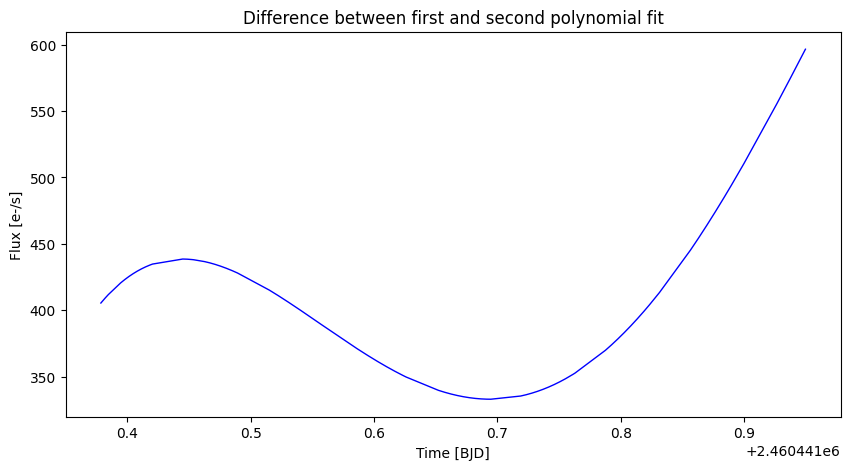

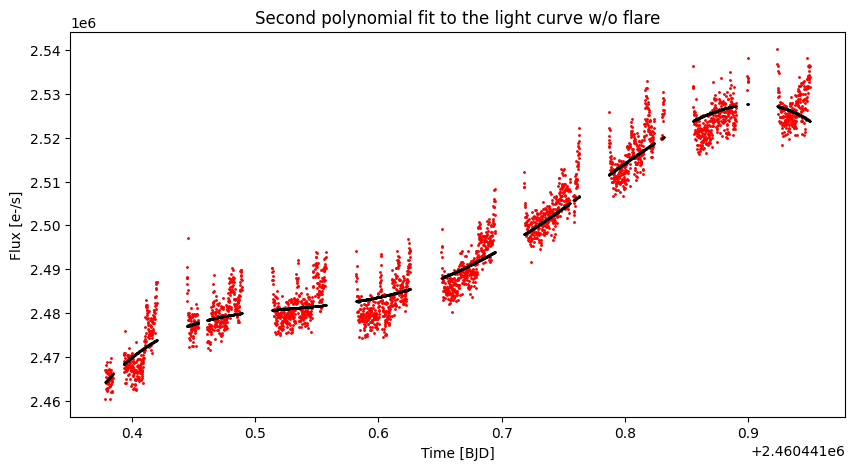

In [116]:
tnew = t[~mask_outliers]
fnew = f[~mask_outliers]
popt, pcov = curve_fit(func, tnew, fnew, p0=popt)

newfitted = func(t, *popt)


newmed = np.median(f[~mask_outliers])
newf_sub = f - fitted + med


plt.figure(figsize=(10, 5))
plt.plot(t, fitted-newfitted, color="blue", lw=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Difference between first and second polynomial fit")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_diff.png")

plt.figure(figsize=(10, 5))

plt.plot(t, f, ".", markersize=1, color="grey")
plt.plot(t, f, ".", markersize=2, color="red")
plt.plot(t, newfitted, ".", markersize=1, color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Second polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_final.png")


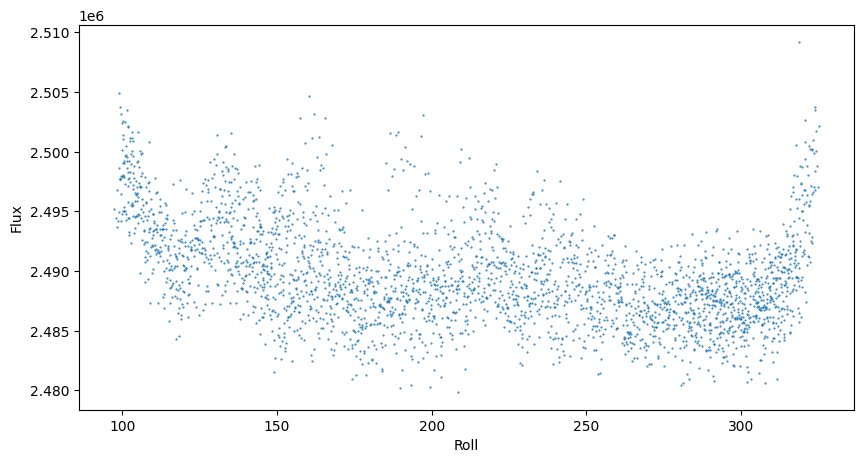

In [117]:
# plot f_sub against roll
plt.figure(figsize=(10, 5))
plt.plot(roll, newf_sub, ".", markersize=1)
plt.xlabel("Roll")
plt.ylabel("Flux")
plt.savefig(f"../plots/{file}/flares/hip67522_roll_flux.png")

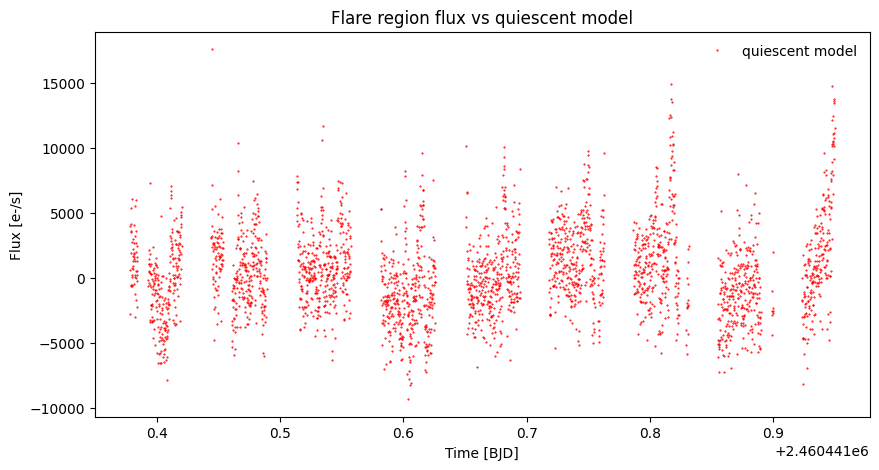

In [118]:
# approximate the flux at the roll values in the flare region with 
# the flux at the closest roll value in the non-flare region

f_sub_no_flare = newf_sub
roll_no_flare = roll

f_sub_no_flare_approx = np.zeros_like(f_sub_no_flare)
for i, r in enumerate(roll_no_flare):
    
    idx = [np.argmin(np.abs(roll_no_flare - r-delt)) for delt in np.linspace(-2, 2, 100)]
    # print(idx)
    f_sub_no_flare_approx[i] = np.median(f_sub_no_flare[idx])


plt.figure(figsize=(10, 5))
plt.plot(t, f_sub_no_flare - f_sub_no_flare_approx, ".", markersize=1, color="red", label="quiescent model")
# plt.plot(t[flare_mask], f_sub_flare, ".", markersize=1, color="blue", label="flare region")
# plt.plot(t[~flare_mask], f_sub_no_flare, ".", markersize=1, color="black", label="non-flare region")
# plt.axhline(newmed, color="black", lw=1)



plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.legend(loc=0, frameon=False)
plt.title("Flare region flux vs quiescent model")
plt.savefig(f"../plots/{file}/flares/hip67522_flare_vs_quiescent_model.png")


/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divi

<ErrorbarContainer object of 3 artists>

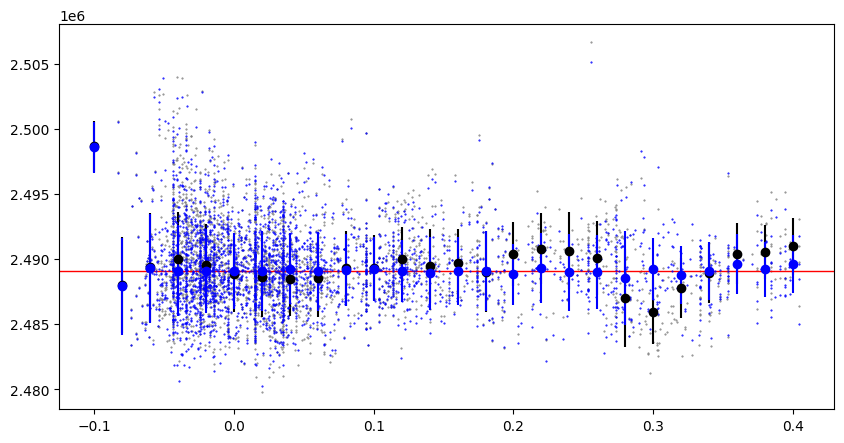

In [129]:
ff = f_sub_no_flare - f_sub_no_flare_approx + newmed

plt.figure(figsize=(10, 5))
plt.plot(dT+12, ff, ".", markersize=1, color="grey")

# bin data in 0.02 dT bins
dTbins = np.arange(-0.1, 0.5, 0.02)
ff_binned = np.zeros_like(dTbins)
ff_err_binned = np.zeros_like(dTbins)
for i, (l, r) in enumerate(zip(dTbins[:-1], dTbins[1:])):
    mask = (dT+12 > l) & (dT+12 < r)
    ff_binned[i] = np.median(ff[mask])
    ff_err_binned[i] = np.std(ff[mask])

plt.errorbar(dTbins[:-1], ff_binned[:-1], yerr=ff_err_binned[:-1], fmt="o", color="black")
plt.axhline(newmed, color="red", lw=1)

# correct quiescent model for the dT-dependent offset using the median of the closest dT 50 data points
ff_corrected = np.zeros_like(ff)
for i, d in enumerate(ff):
    idx = np.argsort(np.abs(dT[i] - dT))
    ff_corrected[i] = d - np.median(ff[idx[:50]])


plt.plot(dT+12, ff_corrected+newmed, ".", markersize=1, color="blue")
    
# bin data in 0.02 dT bins
dTbins = np.arange(-0.1, 0.5, 0.02)
ff_binned = np.zeros_like(dTbins)
ff_err_binned = np.zeros_like(dTbins)
for i, (l, r) in enumerate(zip(dTbins[:-1], dTbins[1:])):
    mask = (dT+12 > l) & (dT+12 < r)
    ff_binned[i] = np.median(ff_corrected[mask])
    ff_err_binned[i] = np.std(ff_corrected[mask])

plt.errorbar(dTbins[:-1], ff_binned[:-1]+newmed, yerr=ff_err_binned[:-1], fmt="o", color="blue")



(3276.981311737231, 3157.7670028855996)

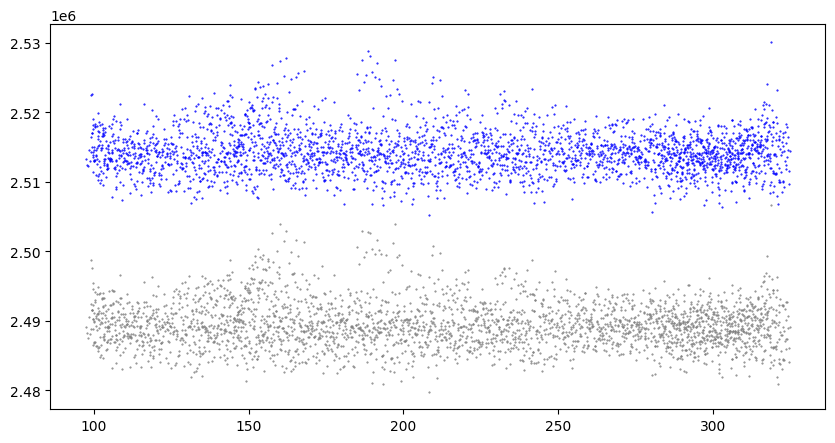

In [168]:
# compare dT corrected vs non-corrected
plt.figure(figsize=(10, 5))
plt.plot(roll, ff, ".", markersize=1, color="grey")
plt.plot(roll, ff_corrected+newmed+25000, ".", markersize=1, color="blue")
# plt.scatter(roll, -dT*9e5-8e6, s=1)

# # bin t, -dT*9e5-8e6 in 0.05 t bins
# tbins = np.arange(t.min(), t.max(), 0.002)
# dT_binned = np.zeros_like(tbins)
# dT_err_binned = np.zeros_like(tbins)
# roll_binned = np.zeros_like(tbins)
# for i, (l, r) in enumerate(zip(tbins[:-1], tbins[1:])):
#     mask = (t > l) & (t < r)
#     dT_binned[i] = np.median(-dT[mask]*9e5-8.2e6)
#     dT_err_binned[i] = np.std(-dT[mask]*9e5-8.2e6)
#     roll_binned[i] = np.median(roll[mask])

# plt.plot(roll_binned[:-1], dT_binned[:-1], c="k")# yerr=dT_err_binned[:-1], fmt="o-", color="black", markersize=1)
np.std(ff),np.std(ff_corrected)

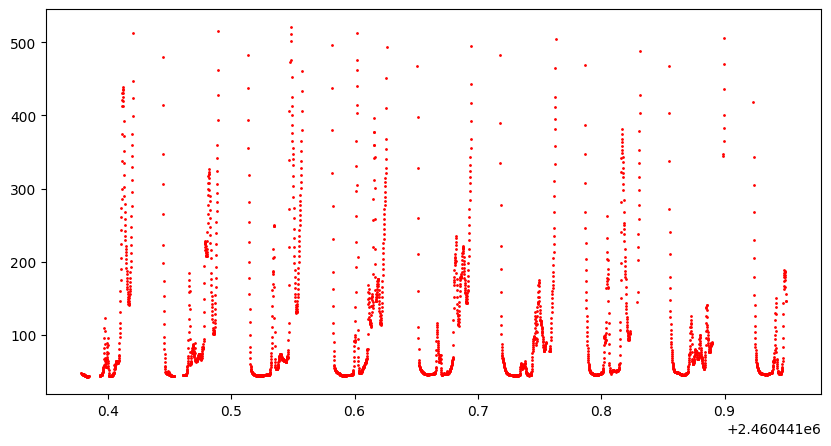

In [175]:
plt.figure(figsize=(10, 5))
# plt.plot(t, f, ".", markersize=1, color="grey")
plt.plot(t, bg, ".", markersize=2, color="red")

In [62]:
flc = FlareLightCurve(time = t, flux = ff, flux_err=np.std(ff))
flc.detrended_flux = ff 
flc.detrended_flux_err = np.std(ff)

flares = flc.find_flares(N1=1,N2=1,N3=2).flares
flares

Found 11 candidate(s) in the (0,3703) gap.
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,384,394,NaN,NaN,2.460429e+06,2.460429e+06,0.772539,0.063187,0.021286,0.001160,3703.0
1,412,414,NaN,NaN,2.460429e+06,2.460429e+06,0.171795,0.038787,0.008572,0.000232,3703.0
2,1127,1129,NaN,NaN,2.460429e+06,2.460429e+06,0.352037,0.038225,0.020581,0.000232,3703.0
3,1143,1145,NaN,NaN,2.460429e+06,2.460429e+06,0.118583,0.038781,0.006020,0.000232,3703.0
4,1514,1517,NaN,NaN,2.460430e+06,2.460430e+06,0.605712,0.072721,0.017356,0.000580,3703.0
5,1943,1946,NaN,NaN,2.460430e+06,2.460430e+06,0.213224,0.047161,0.007748,0.000348,3703.0
6,2389,2391,NaN,NaN,2.460430e+06,2.460430e+06,0.498474,0.057679,0.017132,0.000348,3703.0
7,2811,2813,NaN,NaN,2.460430e+06,2.460430e+06,0.134159,0.038678,0.007193,0.000232,3703.0
8,2834,2836,NaN,NaN,2.460430e+06,2.460430e+06,0.141276,0.038120,0.008370,0.000232,3703.0
9,3588,3590,NaN,NaN,2.460430e+06,2.460430e+06,0.667117,0.049890,0.035045,0.000464,3703.0


/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


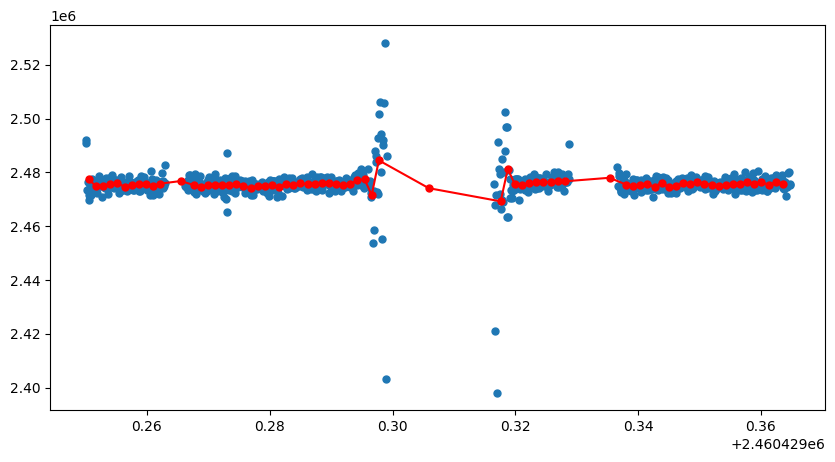

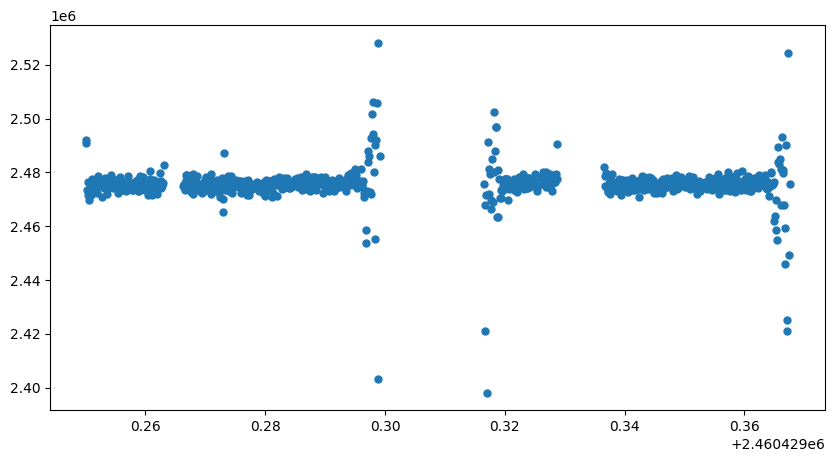

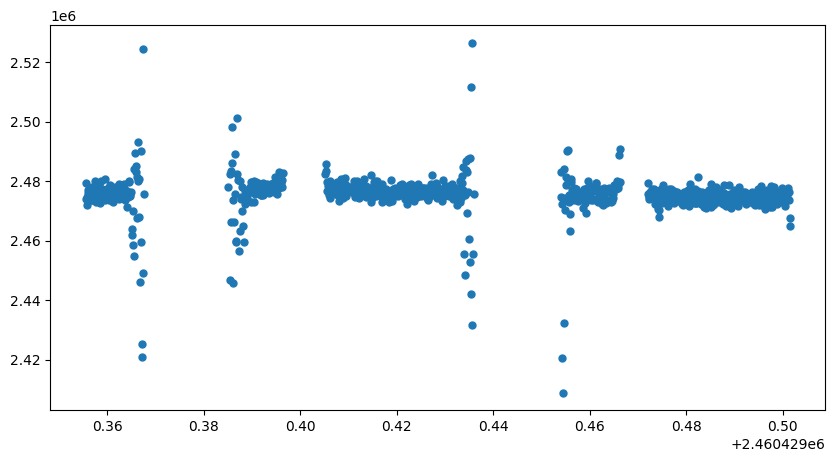

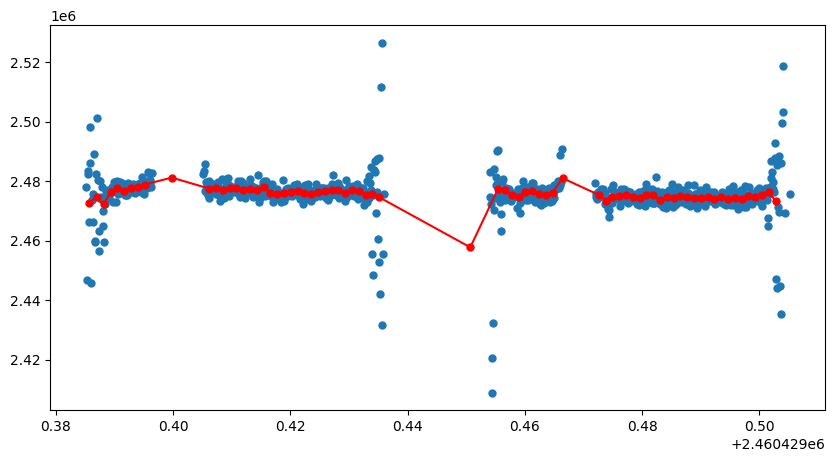

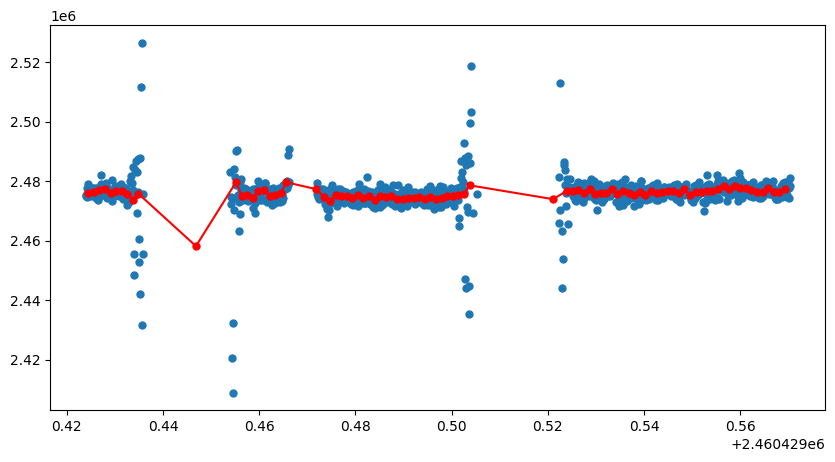

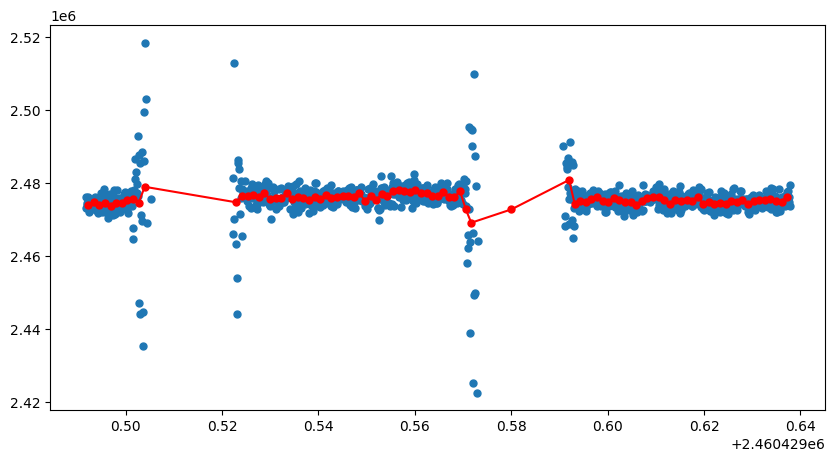

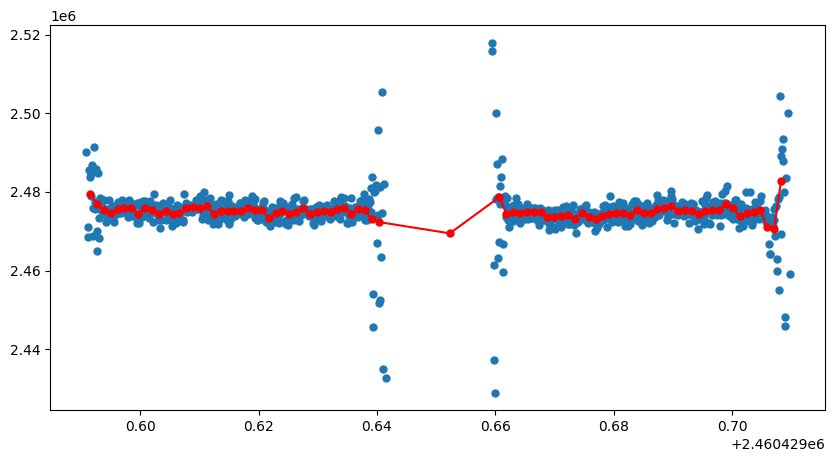

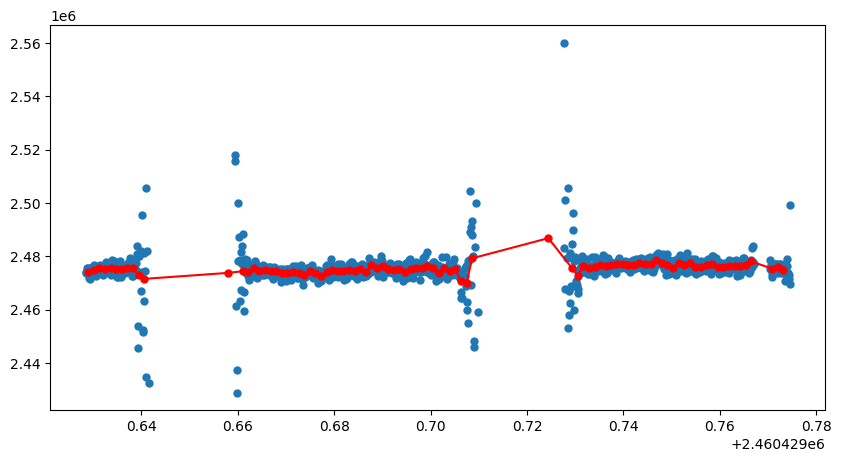

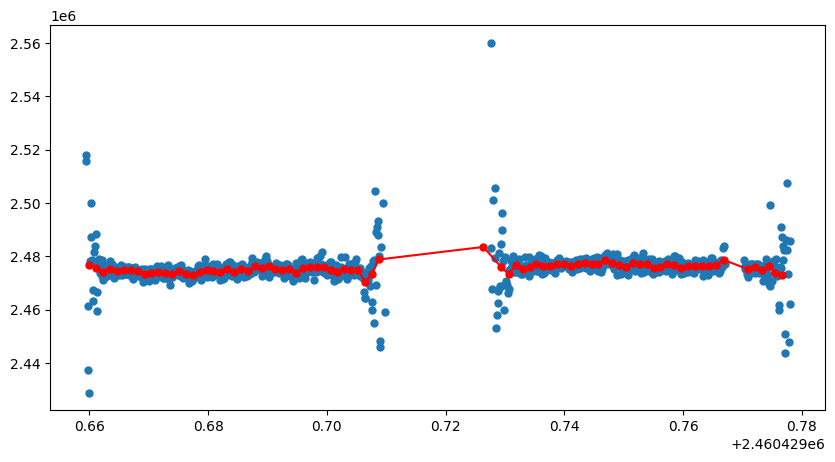

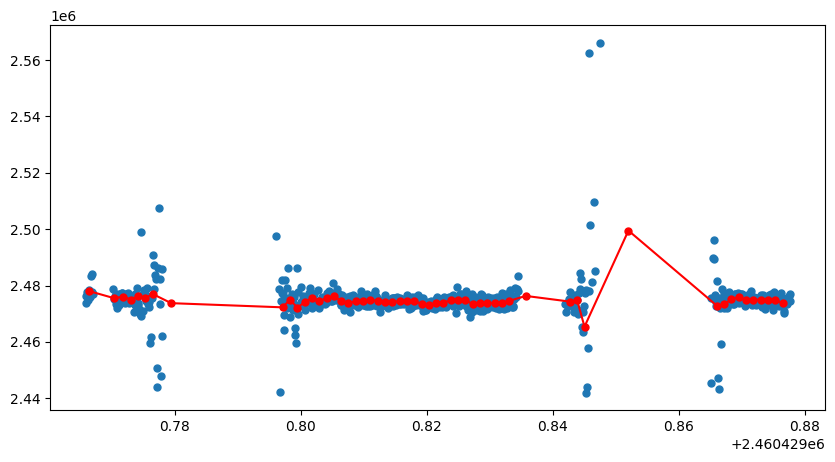

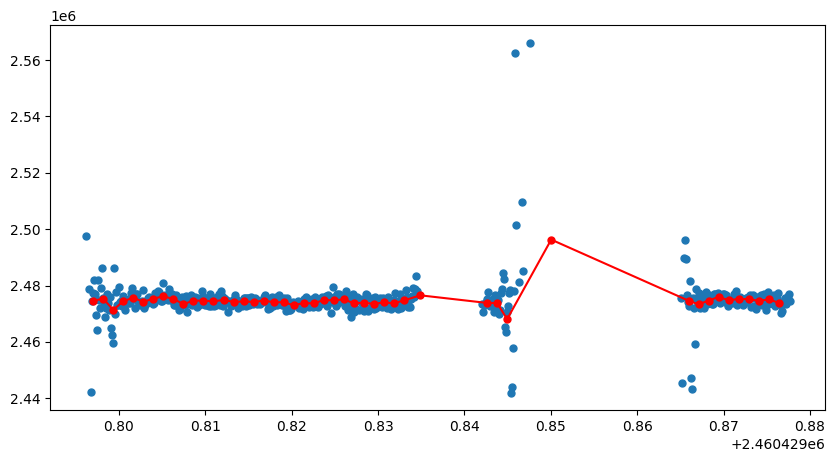

In [63]:
# plot each flare from the flares list
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
    

    flare_m = (t > row.tstart - 0.08) & (t < row.tstop + 0.066)

    tflare = t[flare_m]
    fflare = ff[flare_m]

    plt.plot(tflare, fflare, ".", markersize=10)

    # now bin the data
    binsize = 10

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)

    
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red")